In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error

import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [2]:
mypath = '/Users/jielaizhang/Desktop/waissya/WAISSYA_LCO/Target_A/V/'
outmoviename='mymovie.gif'

In [3]:
# Load in all of the fits images in the directory and sort it

image_list = glob.glob(mypath+'*e91.fits.fz')
image_list.sort()

In [4]:
#Make some useful lists of values to track/record

obstime = []
Bmag = []
Vmag = []
Bmag_e = []
Vmag_e = []
avg_offset = []

In [5]:
# Input the information for the calibration stars identified
# in the previous notebook for batch processing of all of the images

zpt_instrumental = 25.

tar_ra = 299.18555
tar_dec = -1.0214
tar_color = 'yellow'
ref_ra = [299.11433, 299.0763, 299.20659, 299.23568,299.25526]
ref_dec = [-0.84994178, -0.94528461, -1.1268563, -1.2084083,-0.98725623]
ref_colors = ['red','red','red','red','red']
ref_mag = [11.785, 11.194, 11.438,8.634,7.772]

In [6]:
def do_phot_get_mag(data,hdr,err,ra,dec):
    positions = []
    zpt_instrumental = 25.
    w = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot = aperture_photometry(data, apertures, error=err)

    mag = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    dmag = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,dmag

In [7]:
def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

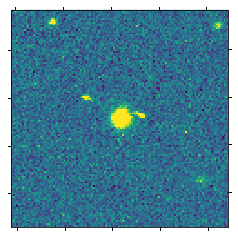

In [8]:
# Let's calculate the star's mag for *each* frame in the dataset

for frame in image_list:
    hdu = fits.open(frame)

    # Grab the actual science data based on above.
    sci_data = hdu[1]
    sci_hdr = sci_data.header
    time = sci_hdr['MJD-OBS']
    obstime.append(time)

    # Background estimation:
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data.data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data.data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

    # Calculate instrumental mags for each of the reference stars
    cal_mag,cal_dmag = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

    # Calculate offsets and the standard deviation of the offset from each star.
    offsets = []
    for i in range(len(cal_mag)):
        offsets.append(ref_mag[i] - cal_mag[i])
    offset = np.mean(offsets)
    avg_offset.append(offset)
    doffset = np.std(offsets)
    
    # Do photometry on the variable target!!
    tar_mag,tar_dmag = do_phot_get_mag(sci_bkg,sci_hdr,error,tar_ra,tar_dec)
    
    cal_tar_mag = tar_mag[0]+offset
    cal_tar_dmag = np.sqrt(tar_dmag[0]**2.+doffset**2.)
    
    Bmag.append(cal_tar_mag)
    Bmag_e.append(cal_tar_dmag)
    
    # Make tiny cutouts of the variable star in each frame
    cutout_hdu = make_cutout(sci_bkg,sci_hdr,tar_ra,tar_dec)
    #cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)
    
    # Plot figures using these cutouts and output images
    interval = ZScaleInterval()
    vmin = interval.get_limits(cutout_hdu.data)[0]
    vmax = interval.get_limits(cutout_hdu.data)[1]

    plt.subplot(projection=wcs.WCS(cutout_hdu.header))
    plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.xlabel('R.A.')
    plt.ylabel('Declination')
    
    pngname = str(time).replace('.','')
    plt.savefig(mypath+pngname+'.png', overwrite=True)

In [9]:
print(len(obstime))
print(len(Bmag))
print(len(image_list))

30
30
30


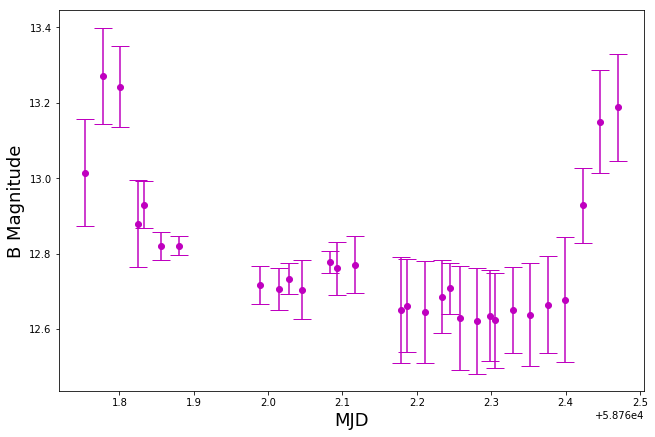

In [10]:
# # Make a rudimentary lightcurve

plt.figure(figsize=(10.5, 7))
plt.errorbar(obstime,Bmag,xerr=None,yerr=Bmag_e, fmt='mo', capsize=9.0)
plt.xlabel('MJD', fontsize=18)
plt.ylabel('B Magnitude', fontsize=18)
plt.show()

In [11]:
# Here we are going to use the cutouts we made above to make
# an little movie of the variable star target changing brightness
# over time and loop it!

import imageio

cutout_list = glob.glob(mypath+'*.png')
cutout_list.sort()

cutout_frames = []
for file in cutout_list:
    cutout_frames.append(imageio.imread(file))
imageio.mimsave(mypath+'mymovie.gif', cutout_frames)

In [13]:
print(Bmag)
print(obstime)
print(Bmag_e)

[12.664045627889704, 12.677947110516568, 13.150303570285882, 13.188312736936796, 12.928228049471057, 13.01484084328257, 13.272085159805442, 13.243011195814082, 12.92900873351311, 12.820866366314261, 12.821365911234253, 12.650753280998932, 12.661797087115634, 12.645605949445109, 12.777124138325789, 12.770683579384272, 12.716612530678814, 12.706379550711663, 12.7334805002395, 12.704072010705186, 12.760812462541299, 12.685538455914704, 12.708197775739233, 12.629135043428075, 12.622204003481265, 12.650251140771651, 12.637559879247092, 12.635217621277922, 12.622371572214037, 12.879524058432553]
[58762.376095, 58762.3994748, 58762.4467173, 58762.4702585, 58762.4230878, 58761.7540147, 58761.777997, 58761.8012602, 58761.8336189, 58761.8566036, 58761.8802159, 58762.178655, 58762.1869199, 58762.2106277, 58762.0837228, 58762.1163182, 58761.9897064, 58762.0140814, 58762.0285247, 58762.0453673, 58762.0925788, 58762.2341957, 58762.2450256, 58762.2578745, 58762.2814057, 58762.328826, 58762.3522663, 5